In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import pathlib

return_series_name = "train/episode_reward"
test_return_series_name = "eval/mean_episode_reward"


# These lines are used to avoid picke errors, credit SO
# https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:


def parse_np_file(file_name, series_name):
    data = np.load(file_name)
    outer_dict = data.reshape(1,)[0]
    key = list(outer_dict.keys())[0]
    dicts = outer_dict[key]
    timesteps = [k for k, v in dicts.items() if series_name in v]
    mean_rews = [d[series_name] for d in dicts.values() if series_name in d]
    
    # For whatever reason in some runs the first timestep logs, and in others it doesn't.
    # For consistency, we just always remove it.
    if len(timesteps) > 0 and timesteps[0] == 0:
        timesteps = timesteps[1:]
        mean_rews = mean_rews[1:]
        
    # For whatever reason, a few runs are logging extra  TODO: make sure this isn't deleting any points we care about
    len_before = len(mean_rews)
    if len(timesteps) > 0:
        new_timesteps = []
        new_mean_rews = []
        for t, m in zip(timesteps, mean_rews):
            if t % 2000 == 0:
                new_timesteps.append(t)
                new_mean_rews.append(m)
        timesteps = new_timesteps
        mean_rews = new_mean_rews
        if len(mean_rews) < len_before:
            print("reduced extra logging; from ", len_before, " to ", len(mean_rews))
        
    
    print("Lengths found", len(mean_rews), len(timesteps))
    assert len(timesteps) == len(mean_rews), (file_name, len(timesteps), len(mean_rews))
    data = np.stack([timesteps, mean_rews], axis=1)
    all_data = pd.DataFrame(data=data, columns=["Steps","Returns"])
    return all_data
    
    
    
def plot_avg(file_names_dict, x_label, y_label, title, save_name=False, last_bold=False, scale=1, 
             load_from_tb=False, base_dir=None, avg_every=None, clip_to=None, series_name=return_series_name,
            include_legend=True, transform_fn=None):
    legend = []

    for file_names in file_names_dict.keys():
        print(file_names)
        runs = []
        steps_list = []
        max_steps = 0
        # Load all the files from numpy arrays
        run_list, alternating = file_names_dict[file_names]
        for seed in run_list:
            full_file_name = os.path.join(base_dir, seed)
            out = parse_np_file(full_file_name, series_name)
            csv = pd.DataFrame(data=out['Returns'].values, columns=['Returns'])
            steps = out['Steps'].values.astype(int)
            if avg_every:
                csv = csv.ewm(span=avg_every).mean()
            
            runs.append(csv)
            steps_list.append(steps)
            
        if len(runs) > 0:
            legend.append(file_names)
            # Pad runs with nan so we only average over whatever points we have
            max_len = max([len(run) for run in runs])
            min_len = min([len(run) for run in runs])
            max_val = max([len(step) for step in steps_list])
            padded_runs = []
            for run in runs:
                pad_run = np.pad(run, (0, max_len - len(run)), 'constant', constant_values=np.nan)
                pad_run = pad_run[:,0]
                padded_runs.append(pad_run)
                
            # We're going to use the longest 'steps' array as our x-axis.  First, check that the steps match
            longest_step = sorted(steps_list, key=len)[-1]
            for step in steps_list:
                if not np.array_equal(step, longest_step[:len(step)]):
                    for i in range(len(step)):
                        if step[i] == longest_step[i]:
                            print("SAME", step[i])
                        else:
                            print("DIFF", step[i], longest_step[i])
                
                
                assert np.array_equal(step, longest_step[:len(step)]), ("Steps don't match", step, longest_step)
            assert len(longest_step) == max_len
                
            # Find the mean and std
            padded_runs = np.stack(padded_runs)
            if transform_fn is not None:
                padded_runs = transform_fn(padded_runs)
            mean_arr = np.nanmean(padded_runs, axis=0)
            std_arr = np.nanstd(padded_runs, axis=0)
 
            # Re-index alternating runs if necessary
            if alternating:
                longest_step, (mean_arr, std_arr) = reindex_runs(longest_step, [mean_arr, std_arr])     
            
            # If necessary, clip all the runs to the same length
            if clip_to is not None:
                if longest_step[-1] >= clip_to:
                    index = np.argmax(longest_step >= clip_to)
                    longest_step = longest_step[:index]
                    mean_arr = mean_arr[:index]
                    std_arr = std_arr[:index]
            
            # Get points for the x- axis
            x = longest_step * scale   
    
            # Actually plot
            plt.plot(x, mean_arr)
            plt.fill_between(x, mean_arr - std_arr, mean_arr + std_arr, alpha=0.2)
        else:
            print("no runs for", file_names)
    
    # Add text to the graph and show it
    if include_legend:
        plt.legend(legend)
    plt.xlabel(x_label, fontdict = {'fontsize' : 16})
    plt.ylabel(y_label, fontdict = {'fontsize' : 16})
    plt.title(title, fontdict = {'fontsize' : 20})
    if save_name:
        plt.savefig(save_name)
    plt.show()

    

In [4]:
pretrain_steps = 180000  # TODO: Set this to collect_sp_itrs + pretrain_sp_itrs + update_sp_itrs
sp_itrs = 10000
policy_itrs = 40000

def is_training_phase(timestep):
    offset = 0
    # Loop through timesteps, alternating between phases
    if timestep == 0:
        return False, 0
    t = 0
    is_policy_phase = False
    while t < timestep:  # TODO: think through < or <=
        if t == 0:
            t += pretrain_steps
            offset += pretrain_steps
        else:
            if is_policy_phase:
                t += policy_itrs
            else:
                t += sp_itrs
                offset += sp_itrs
        is_policy_phase = not is_policy_phase
    return not is_policy_phase, timestep - offset
        

def reindex_runs(steps, arrs):
    # indices says which indices to keep (i.e. which were collected during policy phase)
    results = [is_training_phase(s) for s in steps]
    indices = np.array([r[0] for r in results])
    reindexed_steps = np.array([r[1] for r in results])
    reindexed_steps = reindexed_steps[indices]
    arrs = [a[indices] for a in arrs]
    return reindexed_steps, arrs
    

In [5]:
def plot_final_returns(plot_dict, label_x, label_y, condition, series_name, clip_to=None, scale=.001, save_dir="paper_tb/png_plots"):
    for k, (run_list, alternate) in plot_dict.items():
        full_run_list = [os.path.join(run_name, "eval_scores.npy") for run_name in run_list]
        plot_dict[k] = (full_run_list, alternate)
    
    plot_avg(plot_dict, label_x, label_y, condition,
                 save_name=f"{save_dir}/return_{condition}.png", base_dir=base_path,
                 avg_every=25, scale=scale, clip_to=clip_to, series_name=series_name)



def filter_by_ID(IDs):
    files = []
    for ID in IDs:
        filtered_files = list(filter(lambda x: str(ID) in x, basedir))
        if len(filtered_files) > 0:
            files.append(filtered_files[0])
    return files


In [6]:

def get_sim_param_files(file_path):
    base_dir = pathlib.Path(base_path)
    file_path = base_dir.joinpath(file_path)
    sim_param_files = [f for f in file_path.iterdir() if "agent-sim-params" in f.stem]
    print("len", len(sim_param_files))
    return sim_param_files

def get_sim_param_names(file_path):
    base_dir = pathlib.Path(base_path)
    file_path = base_dir.joinpath(file_path)
    sim_param_files = [f.stem[17:] for f in file_path.iterdir() if "agent-sim-params" in f.stem]
    return sim_param_files

def abs_percent(arr):
    return np.abs(arr) * 100


def plot_spe(run_list, reindex, label_x, label_y, condition, series_name, clip_to=None, scale=.001, save_dir="paper_tb/png_plots"):
    sim_param_names = get_sim_param_names(run_list[0])
    full_run_list = [get_sim_param_files(run_name) for run_name in run_list]
    for i in range(len(sim_param_names)):
        sim_param = sim_param_names[i]
        
        
        # rename things with more interpretable names
        if sim_param[-2:] == '_r':
            sim_param = sim_param[:-2] + "_red_channel"
        if sim_param[-2:] == '_g':
            sim_param = sim_param[:-2] + "_green_channel"
        if sim_param[-2:] == '_b':
            sim_param = sim_param[:-2] + "_blue_channel"
        if sim_param == 'proximal damping':
            sim_param = 'finger_damping'
        if sim_param[:6] == 'hotdog':
            sim_param = 'spinner' + sim_param[6:]
        
        
        sim_param_files = [f[i] for f in full_run_list]
        plot_dict = {"": (sim_param_files, reindex) }
        # sim_param_data is a list of filenames
        plot_title = f"{condition} - {sim_param}"
        plot_avg(plot_dict, label_x, label_y, plot_title,
                 save_name=f"{save_dir}/SPE_{condition}_{sim_param}.png", base_dir="",
                 avg_every=25, scale=scale, clip_to=clip_to, series_name=series_name, include_legend=False,
                transform_fn=abs_percent)
        



# PAPER PLOTS - Return

In [7]:
base_path = "/home/olivia/Sim2Real/Sim2/sim2real2sim_rad/paper_tb/tb_plots/"

In [8]:
spe_label_y = "Sim Param % Error"
test_return_series_name = "mean_ep_reward"
spe_series_name = 'sim_param_error'
policy_label_x = "Policy Steps x 1000"
env_label_x = "Env Steps x 1000"
return_label_y = "'Real' Env Return"
success_label_y = "'Real' Env Success"
test_success_series_name = "mean_ep_success"


## Ball in Cup

Oracle
Lengths found 499 499
Lengths found 124 124
Lengths found 124 124
Ours
Lengths found 124 124
Lengths found 52 52
Baseline
Lengths found 124 124
Lengths found 124 124


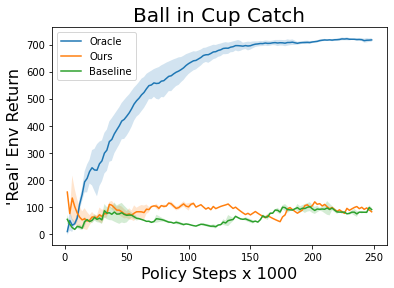

Oracle
Lengths found 499 499
Lengths found 124 124
Lengths found 124 124
Ours
Lengths found 124 124
Lengths found 52 52
Baseline
Lengths found 124 124
Lengths found 124 124


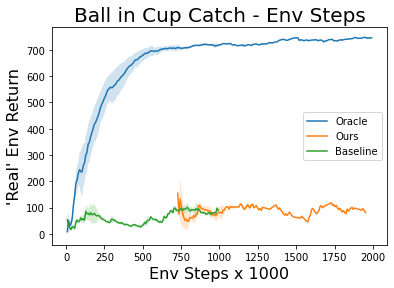

len 10
len 10

Lengths found 71 71
Lengths found 51 51


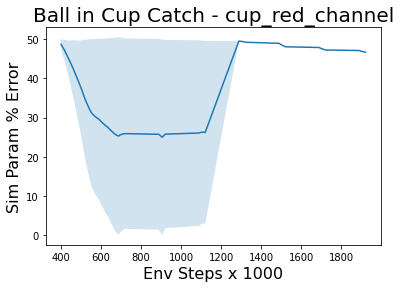


Lengths found 71 71
Lengths found 51 51


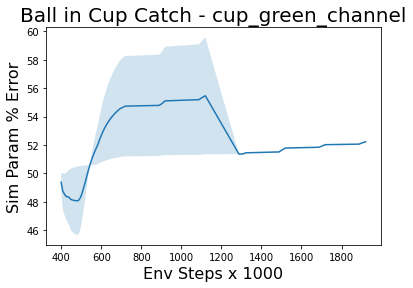


Lengths found 71 71
Lengths found 51 51


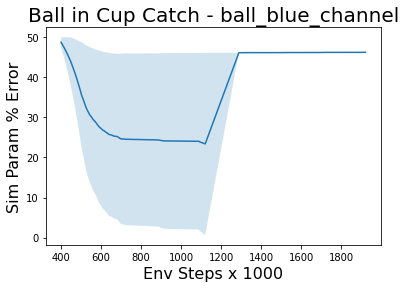


Lengths found 71 71
Lengths found 51 51


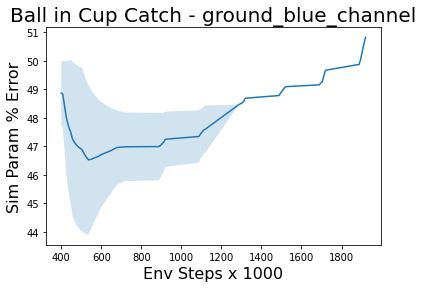


Lengths found 71 71
Lengths found 51 51


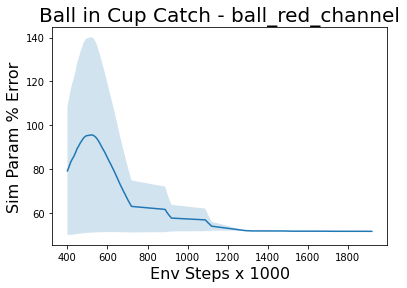


Lengths found 71 71
Lengths found 51 51


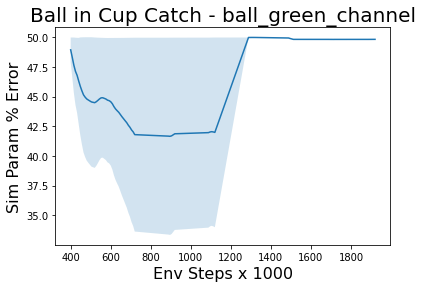


Lengths found 71 71
Lengths found 51 51


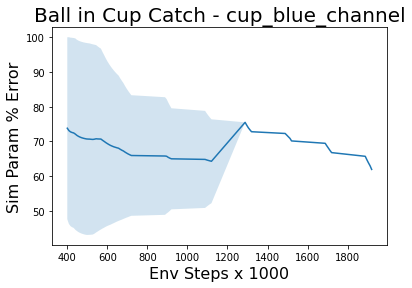


Lengths found 71 71
Lengths found 51 51


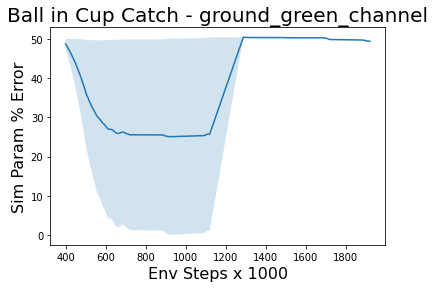


Lengths found 71 71
Lengths found 51 51


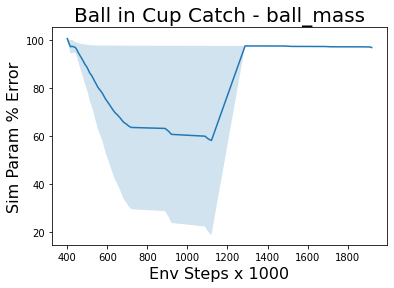


Lengths found 71 71
Lengths found 51 51


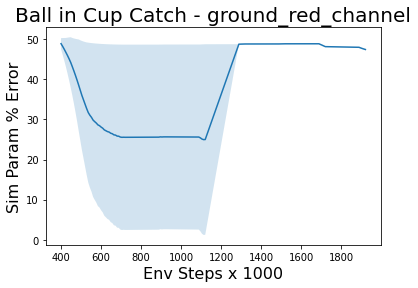

In [9]:
condition = "Ball in Cup Catch"
env_scale = .001 * 4
oracle_runs = [
    "S0602_dmc_ball_in_cup-catch-im84-b128-s2-curl_sac-pixel-crop",
    "S2018_dmc_ball_in_cup-catch-im84-b128-s3-curl_sac-pixel-crop",
    "2048_dmc_ball_in_cup-catch-im84-b128-s5-curl_sac-pixel-crop",
]
ol3_runs = [
    "S3120_dmc_ball_in_cup-catch-im84-b128-s0-curl_sac-pixel-crop",
#     "S3124_dmc_ball_in_cup-catch-im84-b128-s1-curl_sac-pixel-crop",
    "S3128_dmc_ball_in_cup-catch-im84-b128-s2-curl_sac-pixel-crop",
]
baseline_runs = [
    "S2059_dmc_ball_in_cup-catch-im84-b128-s0-curl_sac-pixel-crop",
    "S2032_dmc_ball_in_cup-catch-im84-b128-s1-curl_sac-pixel-crop",
#     "S2036_dmc_ball_in_cup-catch-im84-b128-s2-curl_sac-pixel-crop"
]

plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, True),
    "Baseline": (baseline_runs, False),
}
plot_final_returns(plot_dict, policy_label_x, return_label_y, condition, test_return_series_name, clip_to=250000)


plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, False),
    "Baseline": (baseline_runs, False),
}

plot_final_returns(plot_dict, env_label_x, return_label_y, condition + " - Env Steps", test_return_series_name, clip_to=500000, scale=env_scale)
plot_spe(ol3_runs, False, env_label_x, spe_label_y, condition, spe_series_name, clip_to=None, scale=env_scale)



## Walker

Oracle
Lengths found 499 499
Lengths found 249 249
Lengths found 249 249
Ours
Lengths found 248 248
Lengths found 59 59
Baseline
reduced extra logging; from  411  to  247
Lengths found 247 247
Lengths found 249 249


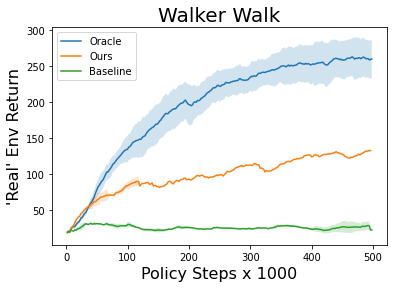

Oracle
Lengths found 499 499
Lengths found 249 249
Lengths found 249 249
Ours
Lengths found 248 248
Lengths found 59 59
Baseline
reduced extra logging; from  411  to  247
Lengths found 247 247
Lengths found 249 249


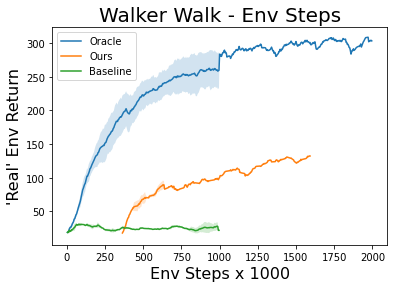

len 7
len 7

Lengths found 101 101
Lengths found 51 51


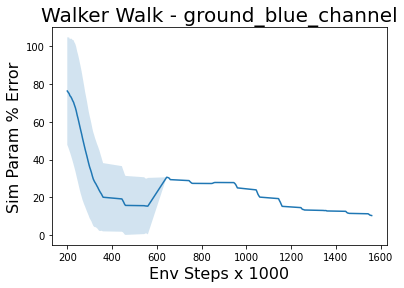


Lengths found 101 101
Lengths found 51 51


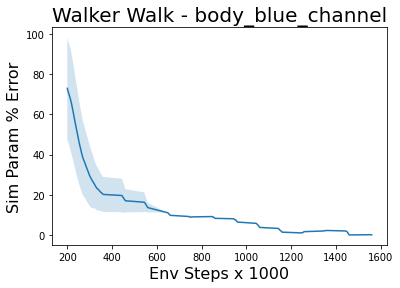


Lengths found 101 101
Lengths found 51 51


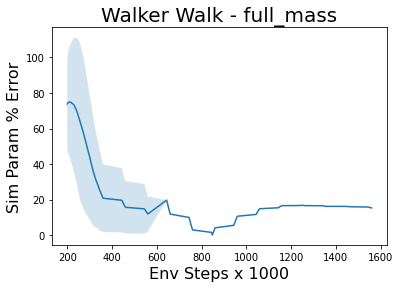


Lengths found 101 101
Lengths found 51 51


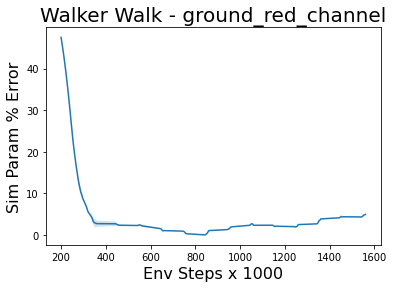


Lengths found 101 101
Lengths found 51 51


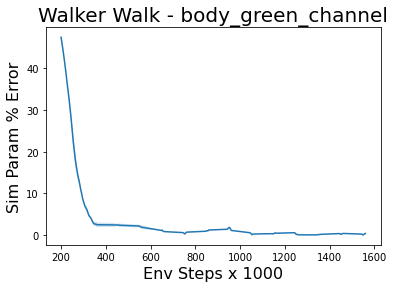


Lengths found 101 101
Lengths found 51 51


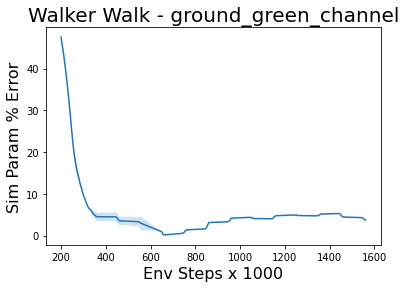


Lengths found 101 101
Lengths found 51 51


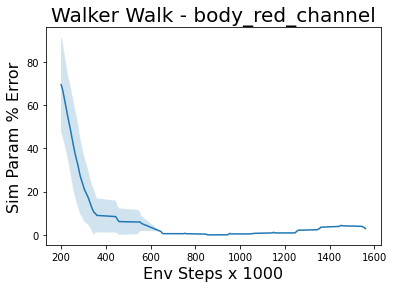

In [10]:
condition = "Walker Walk"
env_scale= .001 * 2
oracle_runs = [
    "S0600_dmc_walker-walk-im84-b128-s2-curl_sac-pixel-crop",
    "S2014_dmc_walker-walk-im84-b128-s3-curl_sac-pixel-crop",
    "2049_dmc_walker-walk-im84-b128-s5-curl_sac-pixel-crop",
]
ol3_runs = [
    "S3121_dmc_walker-walk-im84-b128-s0-curl_sac-pixel-crop",
#     "S3125_dmc_walker-walk-im84-b128-s1-curl_sac-pixel-crop",
    "S3129_dmc_walker-walk-im84-b128-s2-curl_sac-pixel-crop",
]
baseline_runs = [
    "S2060_dmc_walker-walk-im84-b128-s0-curl_sac-pixel-crop",
#     "S2033_dmc_walker-walk-im84-b128-s1-curl_sac-pixel-crop",
    "S2037_dmc_walker-walk-im84-b128-s2-curl_sac-pixel-crop",
]
plot_dict = {
    "Oracle": oracle_runs,
    "Ours": ol3_runs,
    "Baseline": baseline_runs,
}

plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, True),
    "Baseline": (baseline_runs, False),
}
plot_final_returns(plot_dict, policy_label_x, return_label_y, condition, test_return_series_name, clip_to=500000)


plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, False),
    "Baseline": (baseline_runs, False),
}

plot_final_returns(plot_dict, env_label_x, return_label_y, condition + " - Env Steps", test_return_series_name, clip_to=1000000, scale=env_scale)
plot_spe(ol3_runs, False, env_label_x, spe_label_y, condition, spe_series_name, clip_to=None, scale=env_scale)



Oracle
Lengths found 124 124
Lengths found 124 124
Lengths found 124 124
Ours
Lengths found 124 124
Lengths found 124 124
Baseline
Lengths found 124 124
Lengths found 124 124


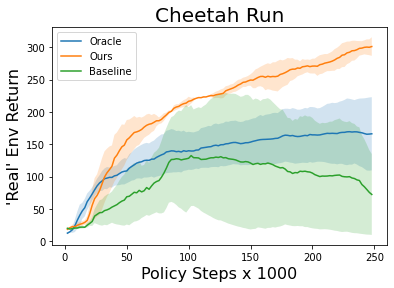

Oracle
Lengths found 124 124
Lengths found 124 124
Lengths found 124 124
Ours
Lengths found 124 124
Lengths found 124 124
Baseline
Lengths found 124 124
Lengths found 124 124


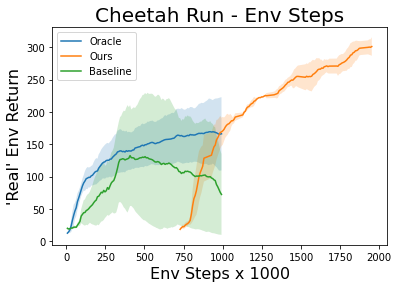

len 7
len 7

Lengths found 71 71
Lengths found 71 71


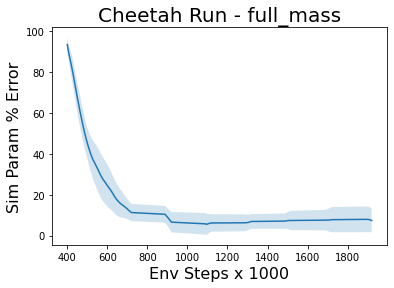


Lengths found 71 71
Lengths found 71 71


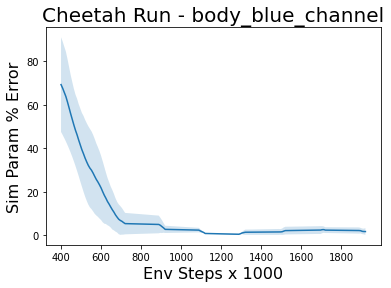


Lengths found 71 71
Lengths found 71 71


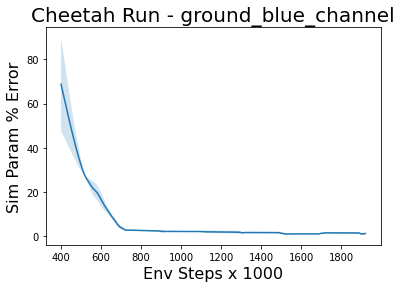


Lengths found 71 71
Lengths found 71 71


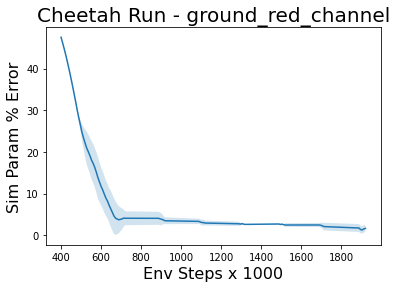


Lengths found 71 71
Lengths found 71 71


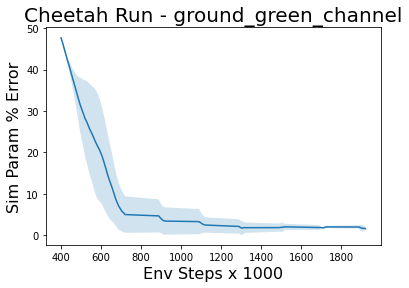


Lengths found 71 71
Lengths found 71 71


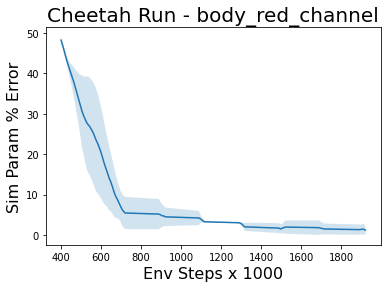


Lengths found 71 71
Lengths found 71 71


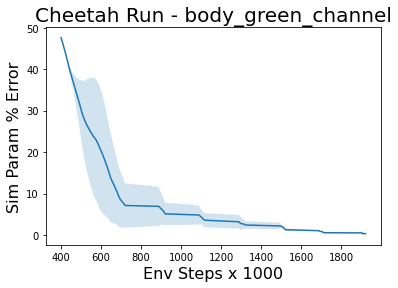

In [11]:
condition = "Cheetah Run"
env_scale = .001 * 4

oracle_runs = [
    "S2019_dmc_cheetah-run-im84-b128-s1-curl_sac-pixel-crop",
    "S2020_dmc_cheetah-run-im84-b128-s2-curl_sac-pixel-crop",
    "2050_dmc_cheetah-run-im84-b128-s5-curl_sac-pixel-crop",
]

ol3_runs = [
    "S3122_dmc_cheetah-run-im84-b128-s0-curl_sac-pixel-crop",
#     "S3126_dmc_cheetah-run-im84-b128-s1-curl_sac-pixel-crop",
    "S3130_dmc_cheetah-run-im84-b128-s2-curl_sac-pixel-crop",
]
baseline_runs = [
    "S2061_dmc_cheetah-run-im84-b128-s0-curl_sac-pixel-crop",
    "S2034_dmc_cheetah-run-im84-b128-s1-curl_sac-pixel-crop",
#     "S2038_dmc_cheetah-run-im84-b128-s2-curl_sac-pixel-crop"
]
plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, True),
    "Baseline": (baseline_runs, False),
}

plot_final_returns(plot_dict, policy_label_x, return_label_y, condition, test_return_series_name, clip_to=250000)


plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, False),
    "Baseline": (baseline_runs, False),
}

plot_final_returns(plot_dict, env_label_x, return_label_y, condition + " - Env Steps", test_return_series_name, clip_to=1000000, scale=env_scale)
plot_spe(ol3_runs, False, env_label_x, spe_label_y, condition, spe_series_name, clip_to=None, scale=env_scale)



Oracle
Lengths found 499 499
Lengths found 249 249
Lengths found 249 249
Ours
Lengths found 249 249
Baseline
Lengths found 163 163
Lengths found 128 128


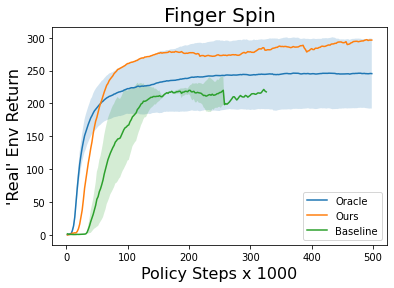

Oracle
Lengths found 499 499
Lengths found 249 249
Lengths found 249 249
Ours
Lengths found 249 249
Baseline
Lengths found 163 163
Lengths found 128 128


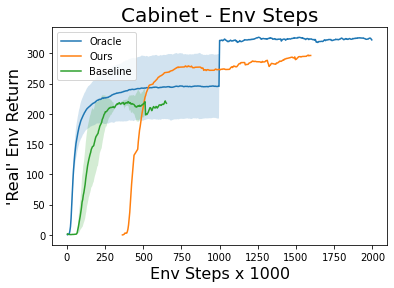

len 11

Lengths found 101 101


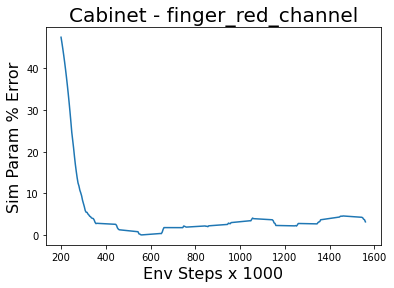


Lengths found 101 101


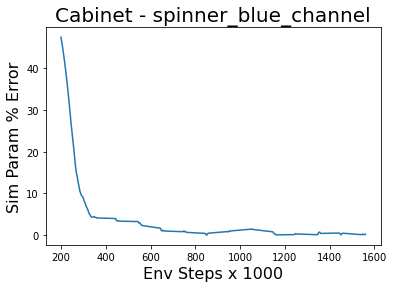


Lengths found 101 101


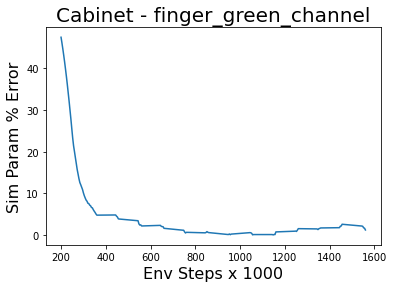


Lengths found 101 101


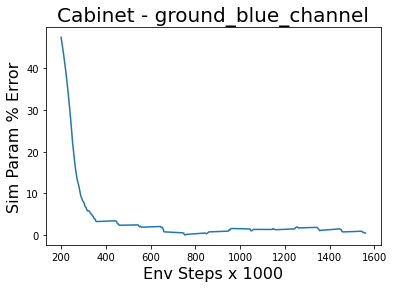


Lengths found 101 101


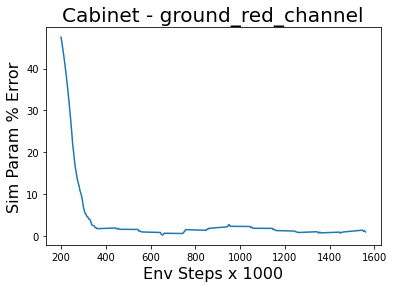


Lengths found 101 101


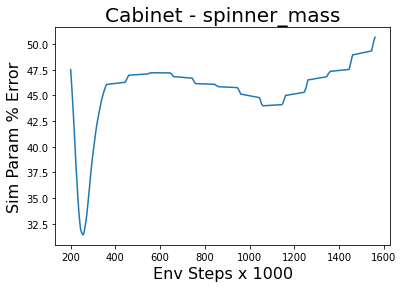


Lengths found 101 101


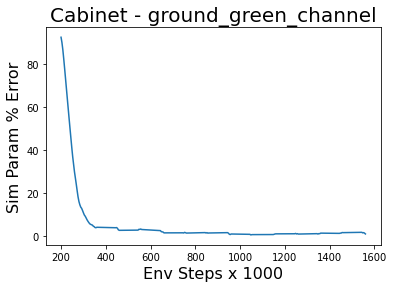


Lengths found 101 101


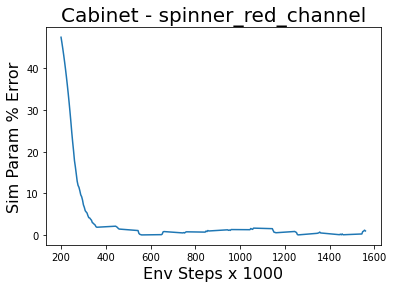


Lengths found 101 101


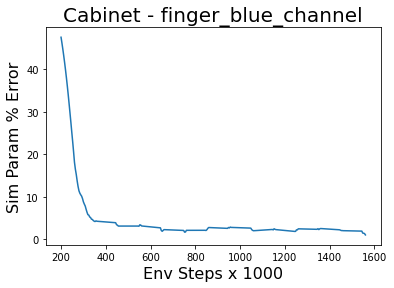


Lengths found 101 101


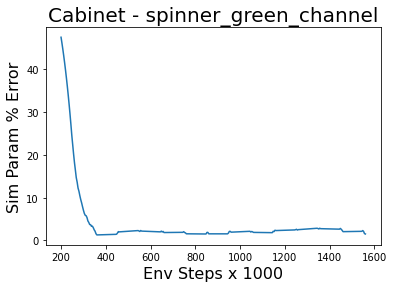


Lengths found 101 101


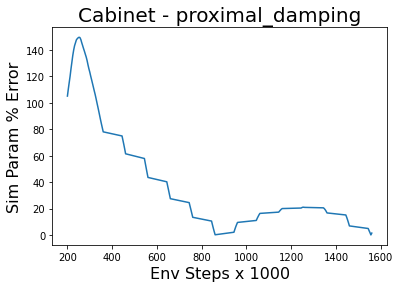

In [12]:
condition = "Finger Spin"
env_scale = .001 * 2

oracle_runs = [
    "S0603_dmc_finger-spin-im84-b128-s2-curl_sac-pixel-crop",
    "S2016_dmc_finger-spin-im84-b128-s3-curl_sac-pixel-crop",
    "2051_dmc_finger-spin-im84-b128-s5-curl_sac-pixel-crop",
]
ol3_runs = [
    "S3123_dmc_finger-spin-im84-b128-s0-curl_sac-pixel-crop",
#     "S3127_dmc_finger-spin-im84-b128-s1-curl_sac-pixel-crop",
#     "S3131_dmc_finger-spin-im84-b128-s2-curl_sac-pixel-crop"
]
baseline_runs = [
#     "S2062_dmc_finger-spin-im84-b128-s0-curl_sac-pixel-crop",
    "S2035_dmc_finger-spin-im84-b128-s1-curl_sac-pixel-crop",
    "S2039_dmc_finger-spin-im84-b128-s2-curl_sac-pixel-crop",
]

plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, True),
    "Baseline": (baseline_runs, False),
}

plot_final_returns(plot_dict, policy_label_x, return_label_y, condition, test_return_series_name, clip_to=500000)

plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, False),
    "Baseline": (baseline_runs, False),
}

# TODO: decide on this!
condition = "Cabinet"
plot_final_returns(plot_dict, env_label_x, return_label_y, condition + " - Env Steps", test_return_series_name, clip_to=1000000, scale=env_scale)
plot_spe(ol3_runs, False, env_label_x, spe_label_y, condition, spe_series_name, clip_to=None, scale=env_scale)



Oracle
Lengths found 249 249
Lengths found 249 249
Lengths found 249 249


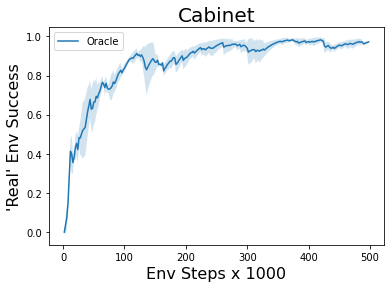

In [13]:
condition = "Cabinet"

# DMC FINGER
oracle_runs = [
    "S0938_kitchen-real_c-im84-b128-s0-curl_sac-pixel-crop",
    "S0939_kitchen-real_c-im84-b128-s1-curl_sac-pixel-crop",
    "S0940_kitchen-real_c-im84-b128-s2-curl_sac-pixel-crop",
]


plot_dict = {
    "Oracle": (oracle_runs, False),
}


plot_final_returns(plot_dict, env_label_x, success_label_y, condition, test_success_series_name, clip_to=500000)
